In [1]:
# Making some fake data figures for planned PRL/PRAB paper(s)
# Imports
import matplotlib.pyplot as plt
import random
try:
    plt.style.use("huntstone")
except:
    plt.style.use("seaborn-colorblind")
import numpy as np
from scipy.constants import c, epsilon_0, elementary_charge
inv_c = 1/c
from scipy.interpolate import interp1d
import sys
# Be sure to include your own path to the python modules
sys.path.insert(0, r'C:\\Users\\khunt\\Documents\\GitHub\\plasma-source\\khuntstone\\eos_bpm\\python\\')
sys.path.insert(0, "/home/keenan/plasma-source/khuntstone/eos_bpm/python/")
import currents as cp
import eo_signal as eos
from plotting import plot_signal

def las_int(x, y, sigr = 0.25e-3):
    I_prof = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            r = np.sqrt(x[i]*x[i]+y[j]*y[j])
            if r > 1.5e-3:
                I_prof[i,j] = 0
            else:
                I_prof[i,j] = np.exp(-r*r/(2*sigr*sigr))
    return I_prof
def get_E(Q, sigz, r):
    sigt = sigz/c
    dt   = 0.1*sigt
    N    = 8000
    t    = np.linspace(-N*dt*0.5, 0.5*dt*N, N)
    E0   = Q/((2*np.pi)**(1.5)*epsilon_0*r*c*sigt)
    E    = E0*np.exp(-t*t/(2*sigt*sigt))
    return E, t

In [2]:
#cpath = "/media/keenan/Data_Storage/Data/currents/"
cpath  = "/mnt/md0/Data/currents/"
setup = {
    "ctype"   : "gap",
    "d"       : 100e-6,
    "y0"      : 800e-9,
    "tp"      : 30e-15,
    "r0"      : 2.5e-3,
    "tau"     : np.linspace(-1000, 1000, 1000)*1e-15,
    "fpath"   : cpath,
    "nslice"  : 100,
    "method"  : "spatial",
    "process" : "cross",
    "angle"   : 15,

}

In [5]:
# Figure: EOS-BPM vs BPM comparison
# Beam paramters
Q    = 0.4e-9 
sigz = 50e-6
r0   = 2.5e-3
# Set nominal offset
N_shots = 100
N_arr   = np.linspace(0, N_shots, N_shots)
dx      = 10e-6*np.sin(np.pi*N_arr/(0.5*N_shots))

In [6]:
# Loop
# Preallocate
x_bpm = np.zeros(N_shots)
x_eos = np.zeros(N_shots)
# Averaging window
window = 50e-15
# Noise
ns = 0.1
# Updates
upd = int(N_shots/10)
for i in range(N_shots):
    if (i+1)%upd == 0:
        print(i+1, "of", N_shots)
    x_bpm[i] = dx[i] + ns*random.random()*random.randrange(-1, 2, 1)*dx[i]
    Q_use    = Q + ns*random.random()*random.randrange(-1, 2, 1)*Q
    sigz_use = sigz + ns*random.random()*random.randrange(-1, 2, 1)*Q
    Ep, tep  = get_E(Q_use, sigz_use, r0 + x_bpm[i])
    Em, tem  = get_E(Q_use, sigz_use, r0 - x_bpm[i])
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam = eos.E_signal(Em, tem, setup)
    Rnum = max(sigp) - max(sigm)
    Rden = max(sigp) + max(sigm)
    R    = Rnum/Rden
    g0   = 2*np.arcsin(np.sqrt(0.5*Rden))
    x_eos[i] = -(r0/g0)*np.tan(0.5*g0)*R

10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100
100 of 100


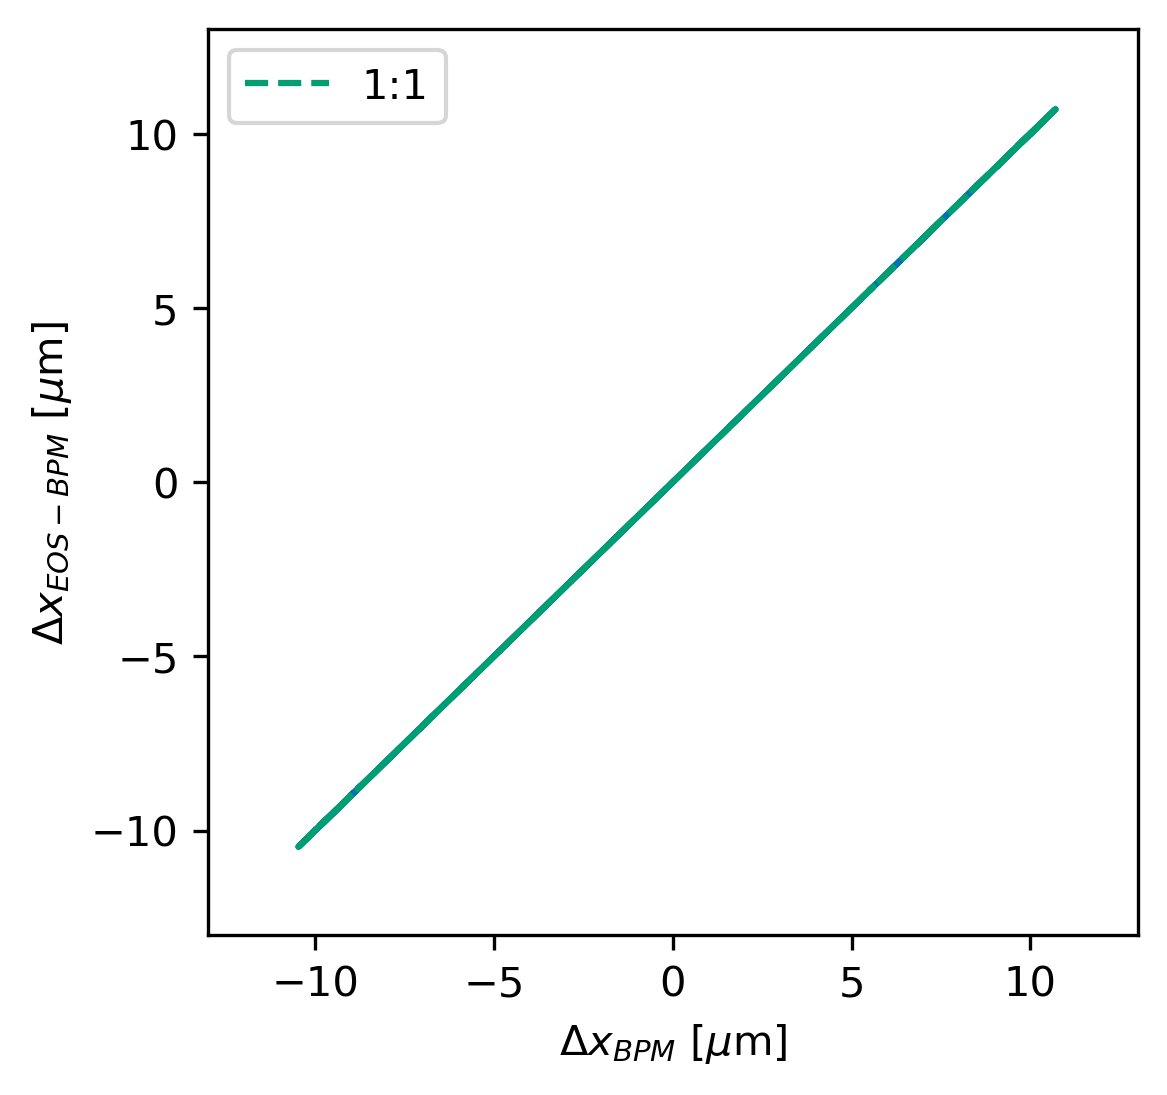

In [9]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel(r'$\Delta x_{BPM}$ [$\mu$m]')
ax.set_ylabel(r'$\Delta x_{EOS-BPM}$ [$\mu$m]')
ax.plot(x_bpm*1e6, x_eos*1e6, '-')
p1, p2 = np.polyfit(x_bpm, x_eos, deg = 1)
fit_line = p1*x_bpm + p2
ax.plot(x_bpm*1e6, fit_line*1e6, '--', label = "1:1")
ax.legend()
ax.set_ylim([-13, 13])
ax.set_xlim([-13, 13])
plt.show()

In [10]:
p1

0.9999876405087617

In [11]:
err = (abs(x_bpm-x_eos)/abs(x_bpm))*1e2
print(np.nanmean(err))

1.01091380953179


/home/keenan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


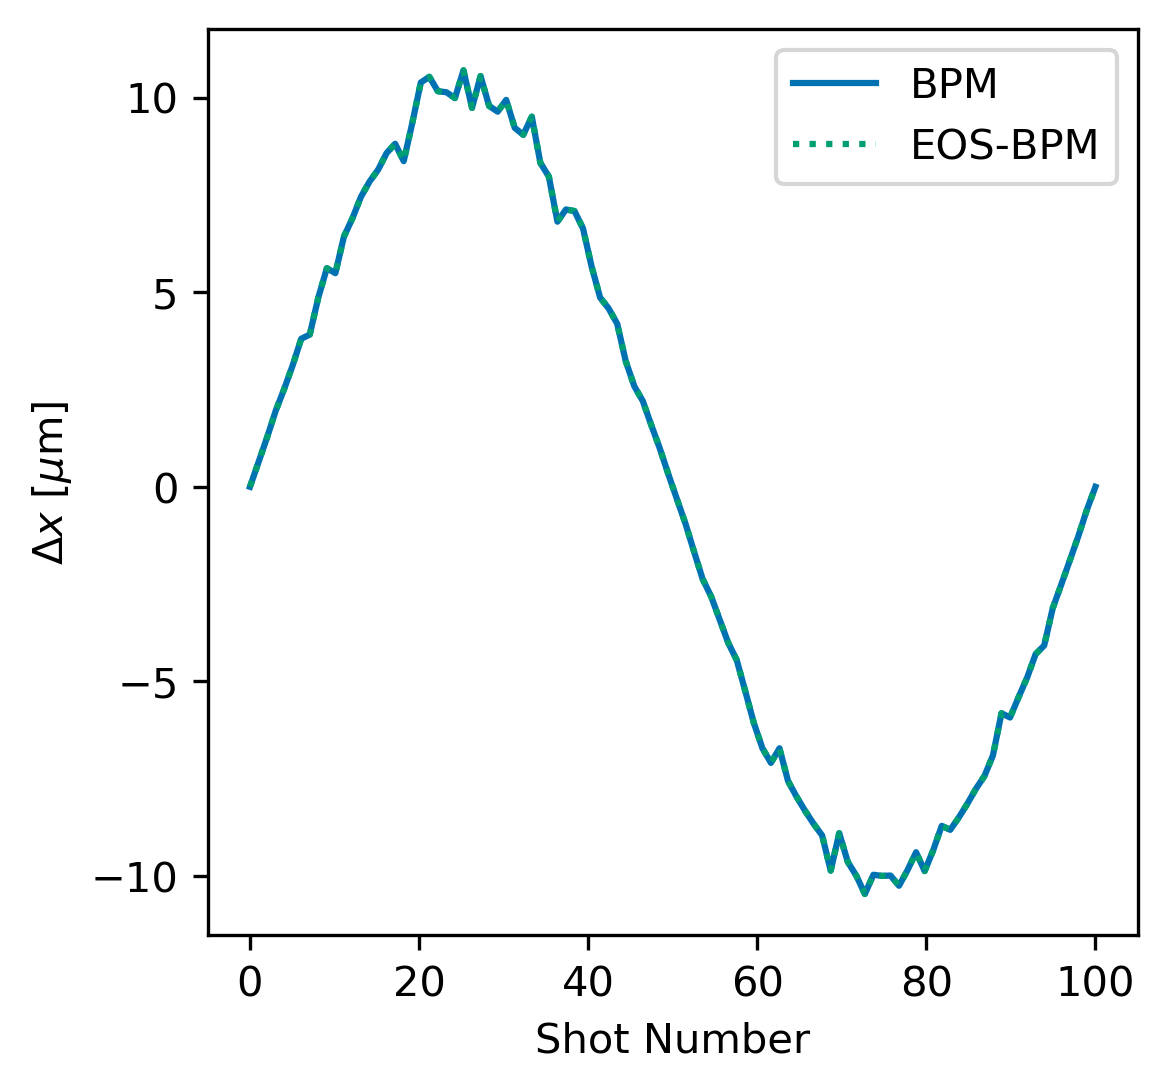

In [12]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Shot Number")
ax.set_ylabel(r'$\Delta x$ [$\mu$m]')
ax.plot(N_arr, x_bpm*1e6, '-', label = "BPM")
ax.plot(N_arr, x_eos*1e6, ':', label = "EOS-BPM")
ax.legend()
plt.show()

In [3]:
# TCAV kicking potential vs EOS-BPM measured position...
# Some constants
gma   = 20000
beta  = np.sqrt(1-1/gma**2)
E     = 10e9 # eV
betad = 0.15 # m
betas = 0.15 # m
dpsi  = 0.78 # rad
phi   = 0*(np.pi/180)
lmd   = 2.6e-2
k     = 2*np.pi/lmd
def get_dx(V0, z):
    pref  = (1/E)*np.sqrt(betad*betas)*np.sin(dpsi)
    dx = (2*np.pi*z/lmd)*np.cos(phi)+np.sin(phi)
    dx = dx*pref*V0
    return dx

In [4]:
I, ti, p2p = cp.get_current(0, cpath)
t_shift = 100e-15
ti = ti + t_shift
zi = c*ti
t_ind = np.argmin(abs(ti-(250e-15+t_shift)))
d_ind = np.argmax(I[0:t_ind])
w_ind = np.argmax(I[t_ind:-1])+t_ind

In [18]:
V0s     = np.linspace(1, 20, 100)*1e6
dxd_tc  = np.zeros(len(V0s))
dxw_tc  = np.zeros(len(V0s))
dxd     = np.zeros(len(V0s))
dxw     = np.zeros(len(V0s))
dx_tc   = np.zeros(len(V0s))
dx_eos  = np.zeros(len(V0s))
upd     = int(len(V0s)/10)
for i in range(len(V0s)):
    if (i+1)%upd == 0:
        print(i+1, "of", len(V0s))
    dx           = get_dx(V0s[i], zi)
    dxd_tc[i]    = dx[d_ind]
    dxw_tc[i]    = dx[w_ind]
    # Drive beam
    rp           = 2.5e-3 + dxd_tc[i]
    rm           = 2.5e-3 - dxd_tc[i]
    Ep, tep      = cp.get_E(I, ti, rp)
    Em, tem      = cp.get_E(I, ti, rm)
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam  = eos.E_signal(Em, tem, setup)
    tw_ind = np.argmin(abs(tsigp-250e-15))
    indd   = np.argmax(sigp[0:tw_ind])
    # Centroid position
    Rd_num = sigp[indd] - sigm[indd]
    Rd_den = sigp[indd] + sigm[indd]
    Rd     = Rd_num/Rd_den
    g0d    = 2*np.arcsin(np.sqrt(0.5*Rd_den))
    dxd[i] = -(2.5e-3/g0d)*np.tan(0.5*g0d)*Rd
    # Witness beam
    rp     = 2.5e-3+dxw_tc[i]
    rm     = 2.5e-3-dxw_tc[i]
    Ep, tep      = cp.get_E(I, ti, rp)
    Em, tem      = cp.get_E(I, ti, rm)
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam  = eos.E_signal(Em, tem, setup)
    tw_ind = np.argmin(abs(tsigp-250e-15))
    indw   = np.argmax(sigp[tw_ind:-1]) + tw_ind
    # Witness centroid position
    Rw_num = sigp[indw] - sigm[indw]
    Rw_den = sigp[indw] + sigm[indw]
    Rw     = Rw_num/Rw_den
    g0w    = 2*np.arcsin(np.sqrt(0.5*Rw_den))
    dxw[i] = -(2.5e-3/g0w)*np.tan(0.5*g0w)*Rw
    
    
    dx_tc[i]  = dxd_tc[i] - dxw_tc[i]
    dx_eos[i] = dxd[i] - dxw[i]

10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100
100 of 100


In [20]:
np.argmin(abs(-dx_eos*1e6-1.0))

6

In [22]:
V0s[6]*1e-6

2.1515151515151514

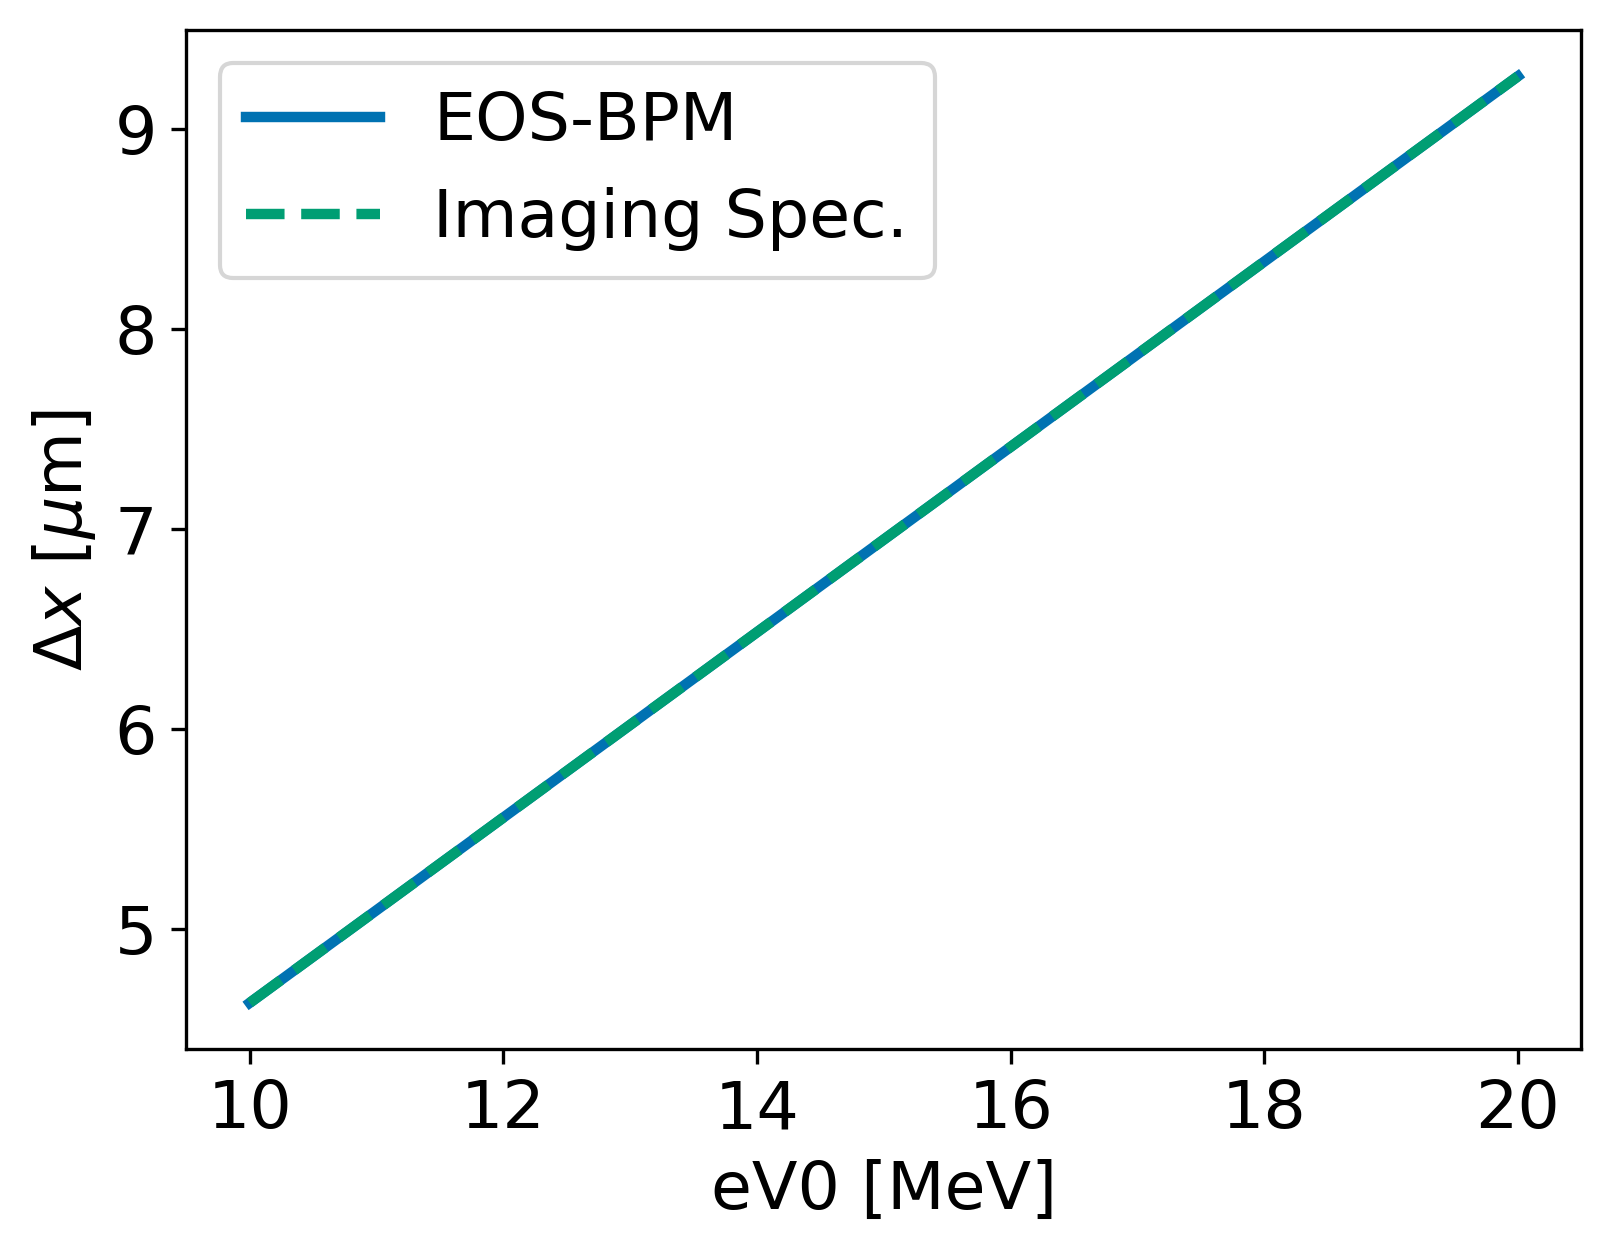

In [15]:
fig = plt.figure(figsize = (6, 4.5), dpi = 300)
ax  = fig.gca()
fs  = 16
lw  = 2.5
ax.tick_params(axis="both", labelsize = fs)
ax.set_xlabel("eV0 [MeV]", fontsize = fs)
ax.set_ylabel(r'$\Delta x$ [$\mu$m]', fontsize = fs)
ax.plot(V0s*1e-6, -dx_eos*1e6, label = "EOS-BPM", linewidth=lw)
ax.plot(V0s*1e-6, -dx_tc*1e6, '--',label = "Imaging Spec.", linewidth=lw)
ax.legend(fontsize = fs)
plt.show()

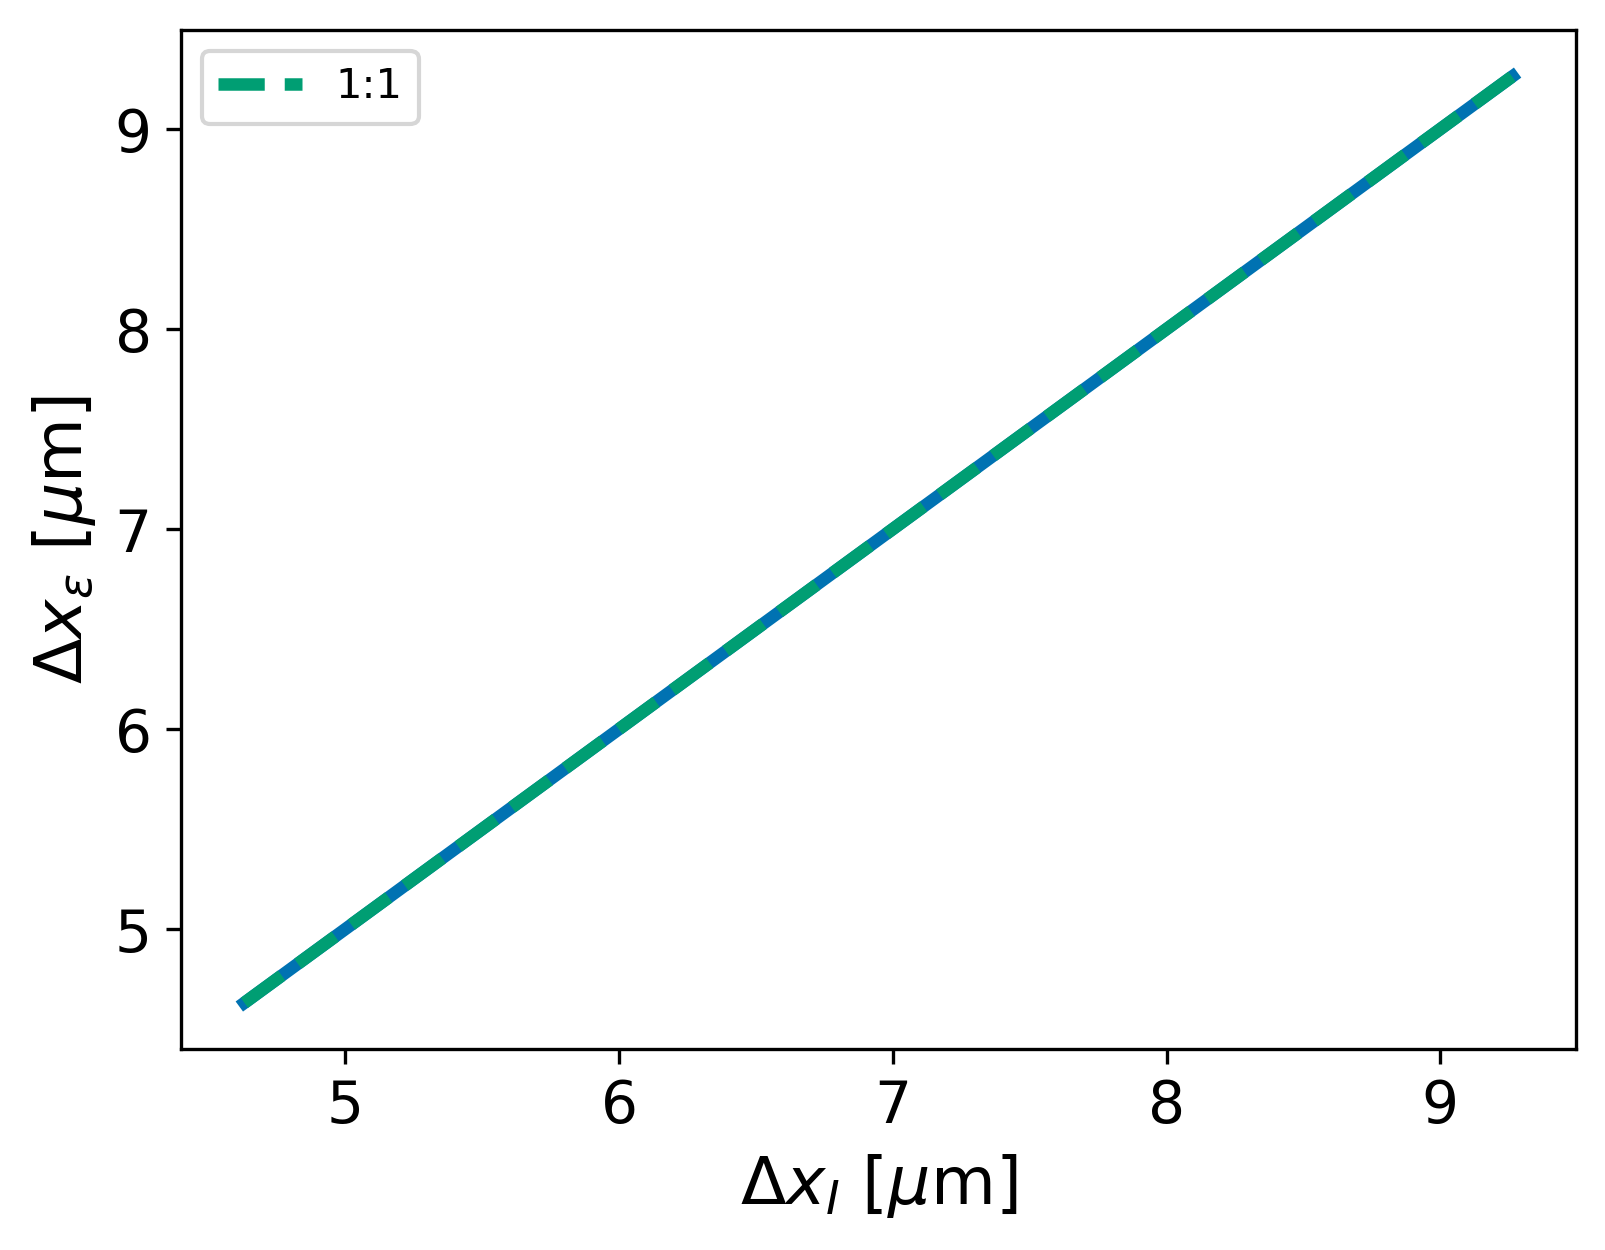

In [22]:
fig = plt.figure(figsize = (6,4.5), dpi = 300)
ax  = fig.gca()
fs  = 16
ax.set_xlabel(r'$\Delta x_I$ [$\mu$m]', fontsize = fs)
ax.set_ylabel(r'$\Delta x_{\epsilon}$ [$\mu$m]', fontsize = fs)
ax.plot(-dx_tc*1e6, -dx_eos*1e6, lw=3)
ax.plot(-dx_tc*1e6, -dx_tc*1e6, '--', label = "1:1", lw=3)
ax.tick_params(axis = "both", labelsize = 14)
ax.legend()
plt.show()

In [42]:
dxd_screen = np.zeros(len(V0s))
dxw_screen = np.zeros(len(V0s))
dxd_bpm    = np.zeros(len(V0s))
dxw_bpm    = np.zeros(len(V0s))
for i in range(len(V0s)):
    pref  = (1/E)*np.sqrt(betad*0.25)*3.0
    dx = (2*np.pi*zi/lmd)*np.cos(phi)+np.sin(phi)
    dx = dx*pref*V0s[i]
    dxd_screen[i] = dx[d_ind]
    dxw_screen[i] = dx[w_ind]
    dx = get_dx(V0s[i], zi)
    dxd_bpm[i] = dx[d_ind]
    dxw_bpm[i] = dx[w_ind]
print("Done")

Done


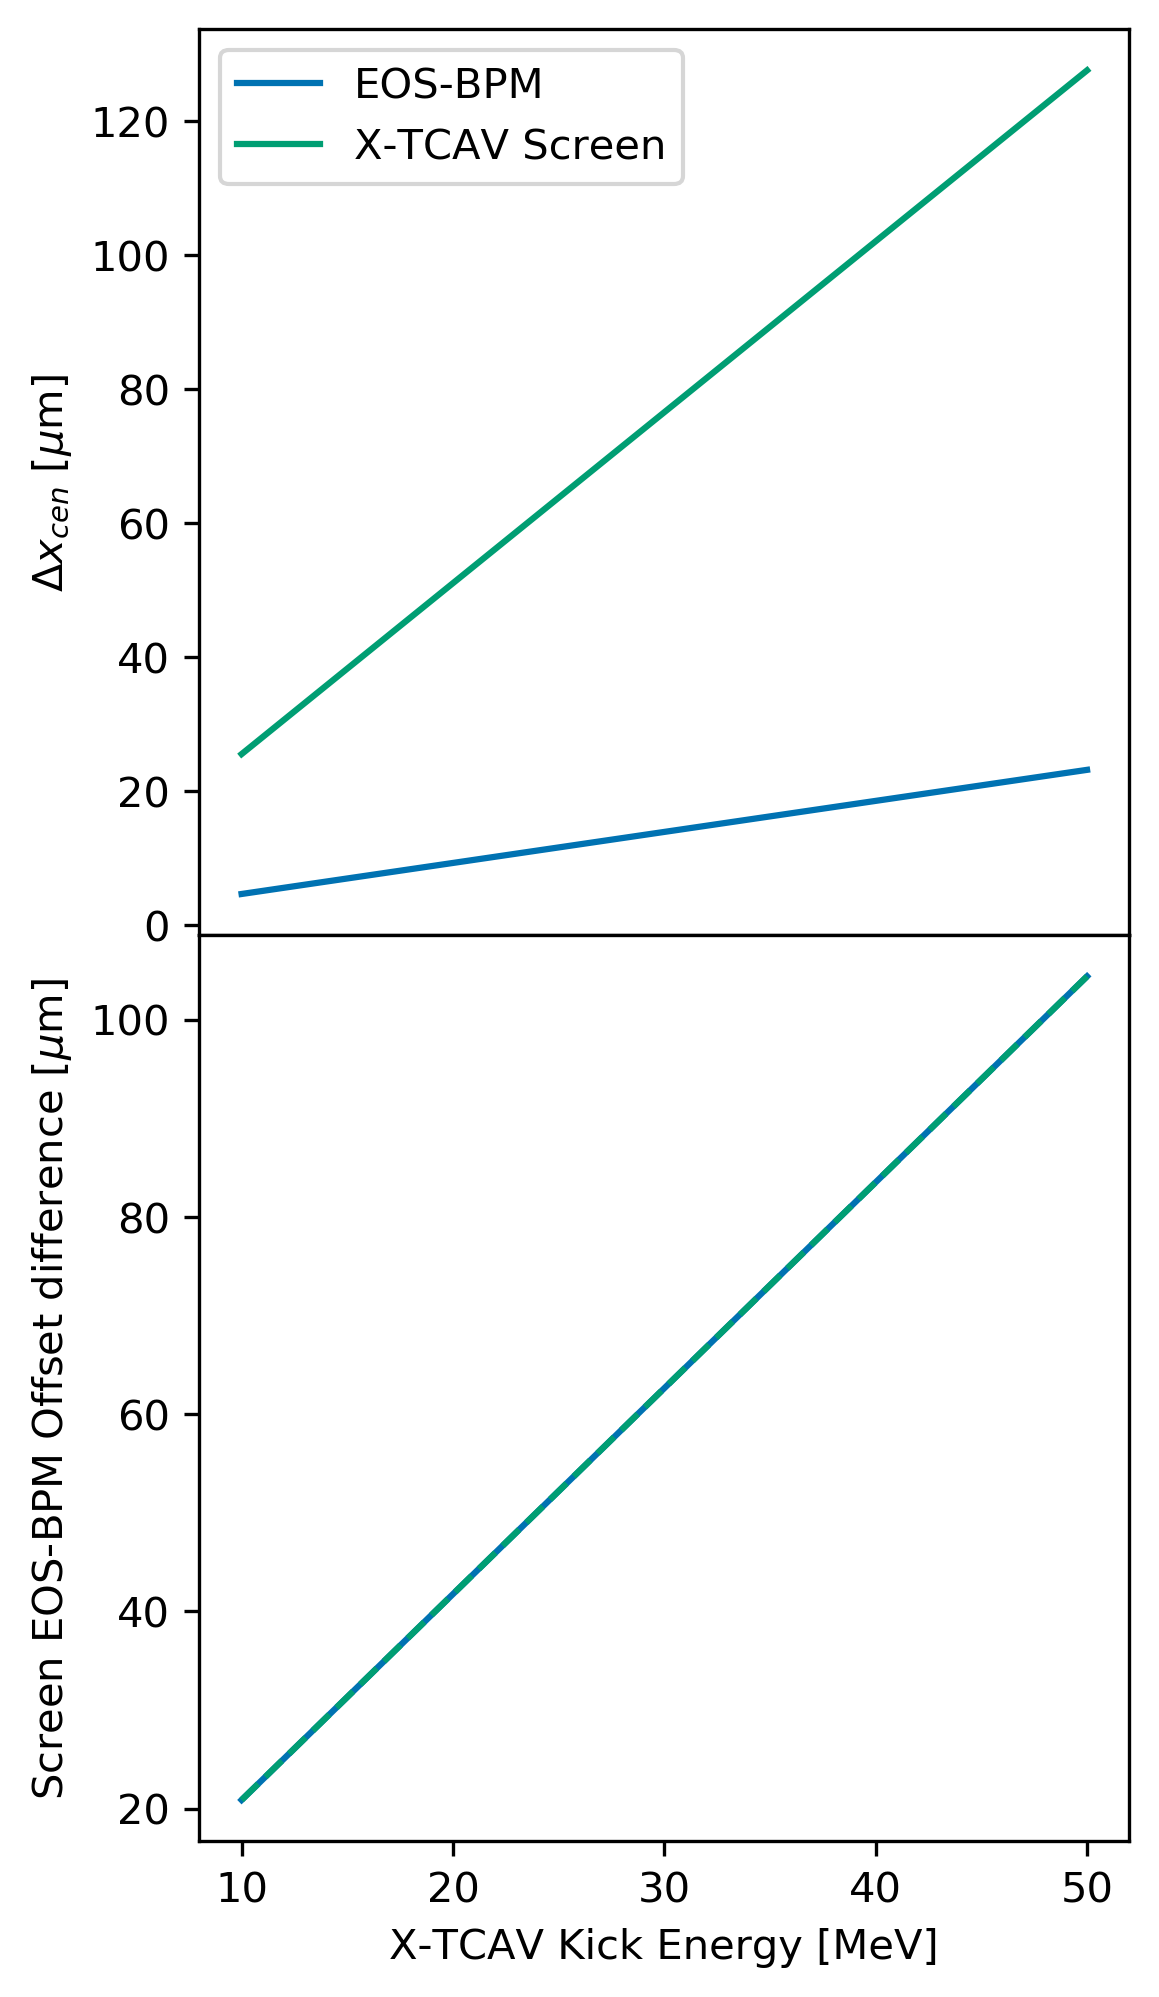

In [45]:
fig = plt.figure(figsize = (4,8), dpi = 300)
ax1 = fig.add_subplot(211)
dx_screen = -(dxd_screen-dxw_screen)
ax1.plot(V0s*1e-6, -dx_eos*1e6, label = "EOS-BPM")
ax1.plot(V0s*1e-6, dx_screen*1e6, label = "X-TCAV Screen")
ax1.set_ylabel(r'$\Delta x_{cen}$ [$\mu$m]')
ax1.set_xticks([])
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.plot(V0s*1e-6, (dx_screen + dx_eos)*1e6, label = "Experiment")
dx_bpm = dxd_bpm - dxw_bpm
ax2.plot(V0s*1e-6, (dx_screen + dx_bpm)*1e6, '--', label = "Eqn. (8)")
ax2.set_ylabel(r'Screen EOS-BPM Offset difference [$\mu$m]')
ax2.set_xlabel("X-TCAV Kick Energy [MeV]")
plt.subplots_adjust(hspace=0)
plt.show()

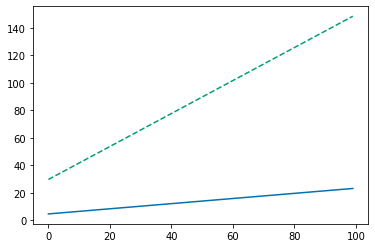

In [26]:
plt.plot(-dx_eos*1e6)
plt.plot(-(dxd_screen-dxw_screen*1e6), '--')
plt.show()

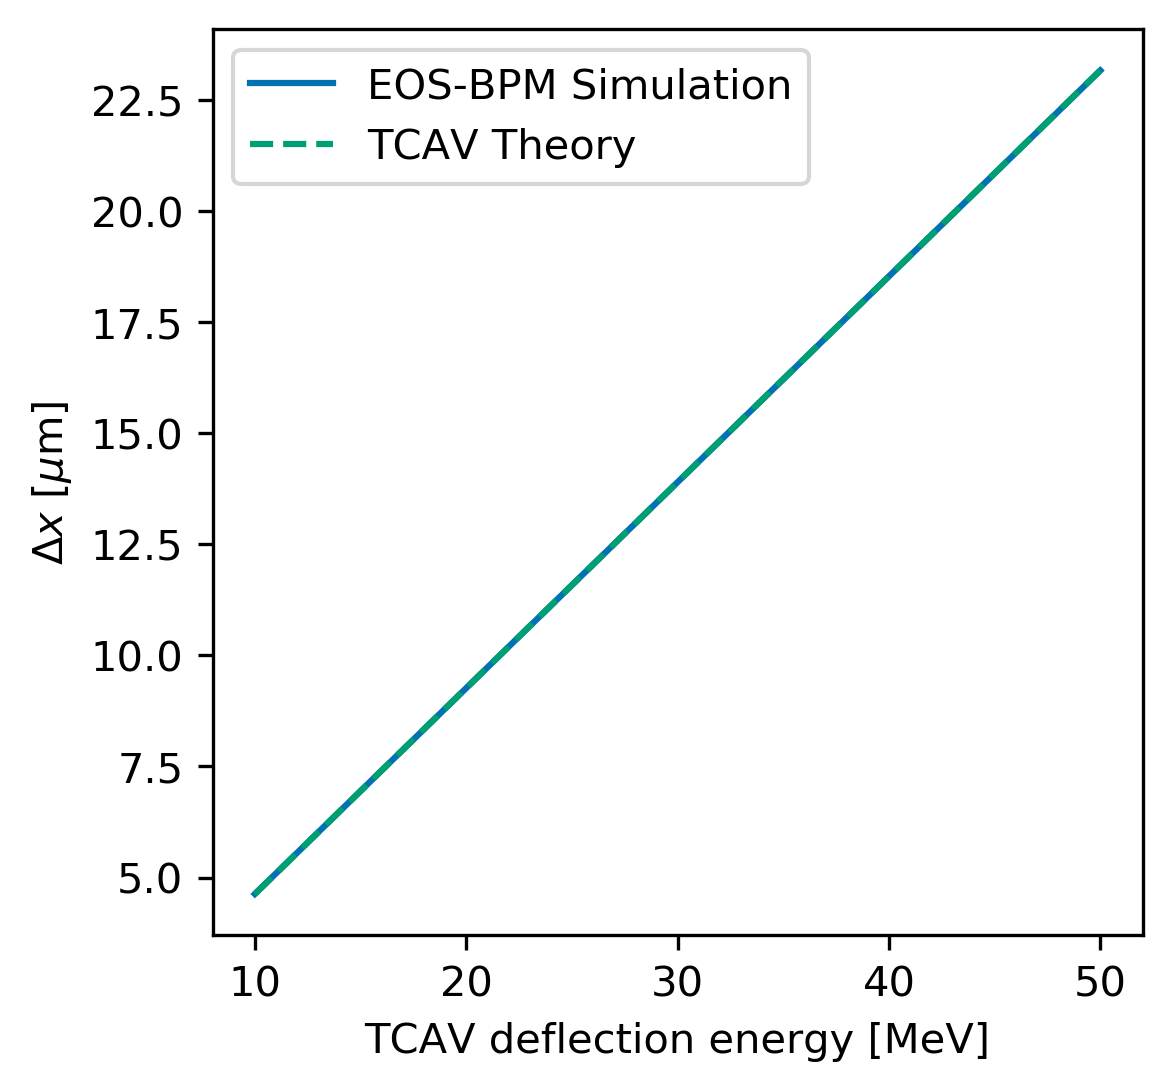

In [21]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_ylabel(r'$\Delta x$ [$\mu$m]')
ax.set_xlabel("TCAV deflection energy [MeV]")
ax.plot(V0s/1e6, -dx_eos*1e6, '-', label = "EOS-BPM Simulation")
ax.plot(V0s/1e6, -dx_tc*1e6, '--', label = "TCAV Theory")
ax.legend()
plt.show()

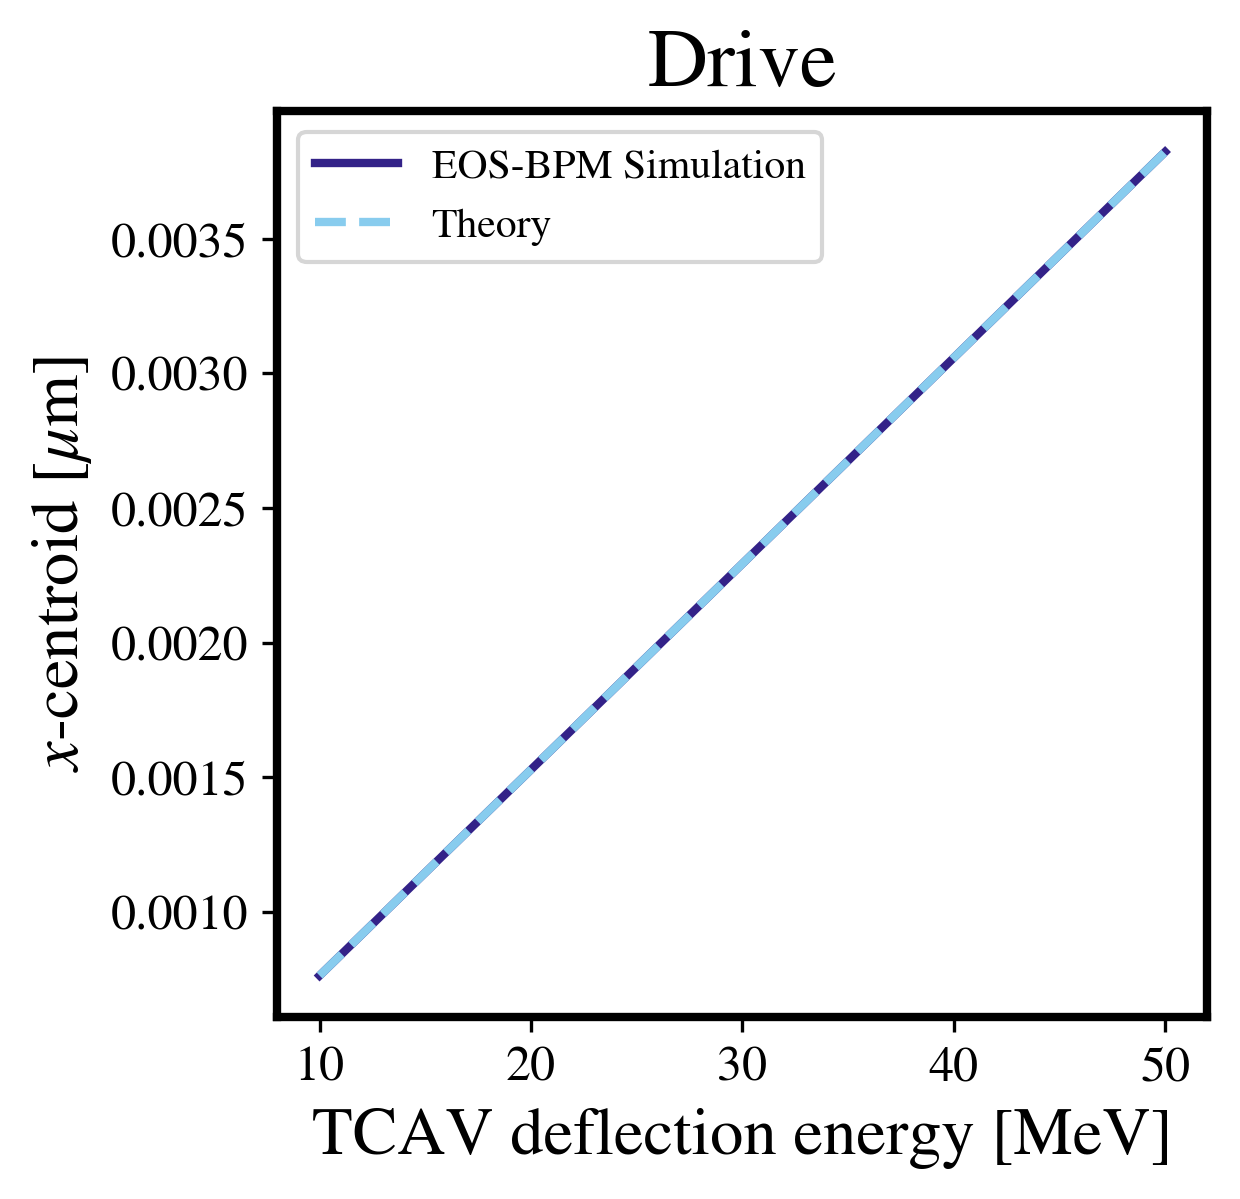

In [38]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_ylabel(r'$x$-centroid [$\mu$m]')
ax.set_xlabel("TCAV deflection energy [MeV]")
ax.plot(V0s/1e6, dxd*1e3, '-', label = "EOS-BPM Simulation")
ax.plot(V0s/1e6, dxd_tc*1e3, '--', label = "Theory")
ax.set_title("Drive")
ax.legend()
plt.show()

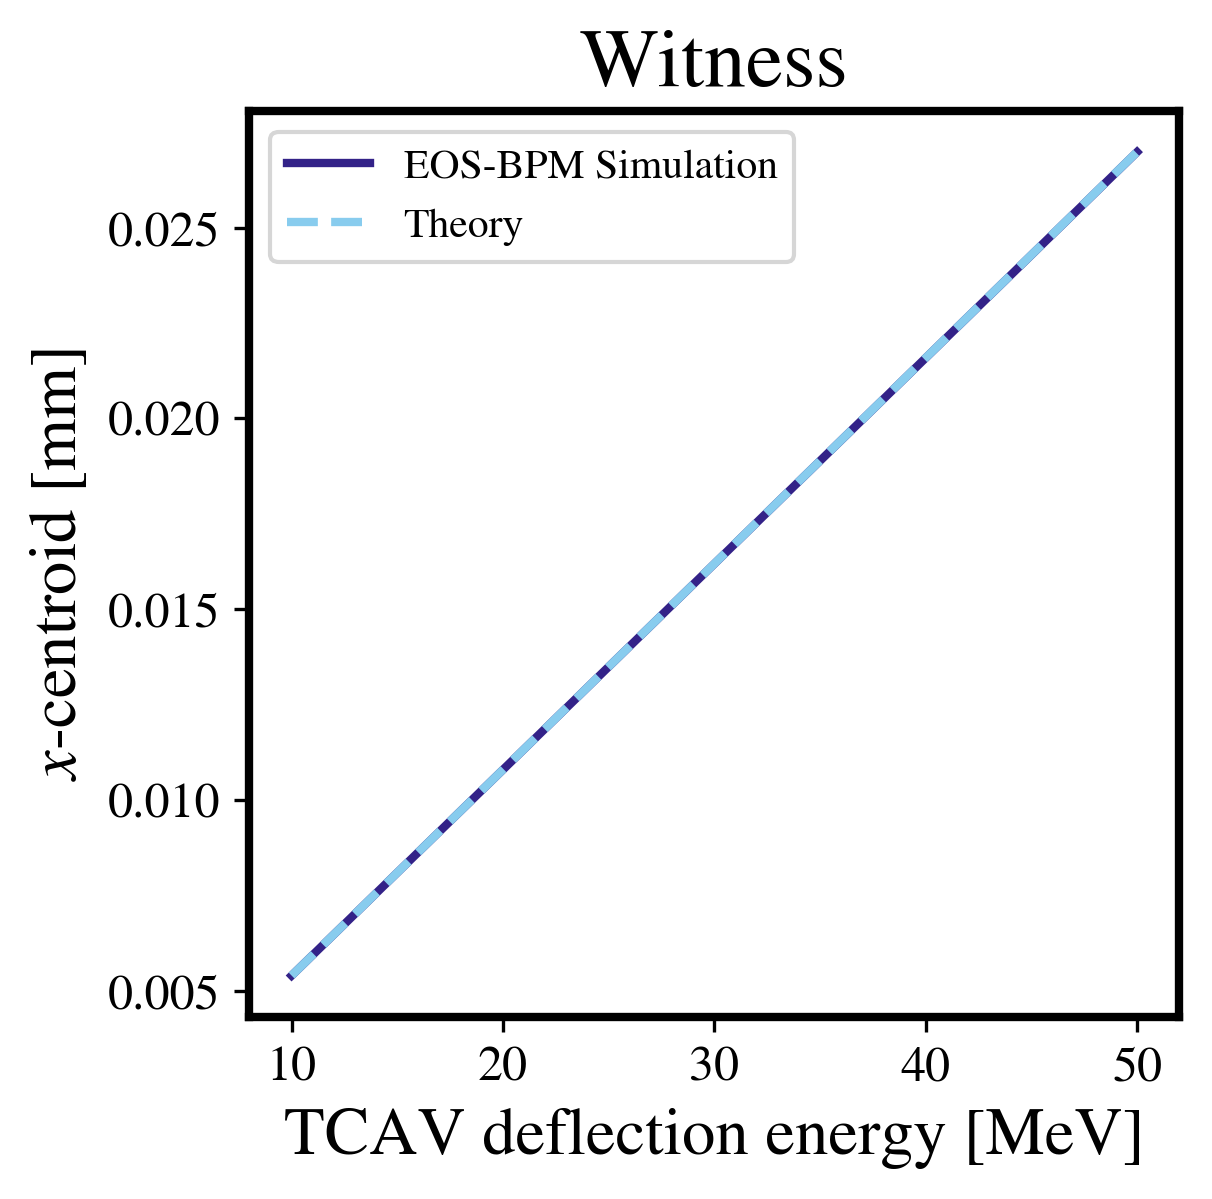

In [37]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_ylabel(r'$x$-centroid [mm]')
ax.set_xlabel("TCAV deflection energy [MeV]")
ax.plot(V0s*1e-6, dxw*1e3, '-', label = "EOS-BPM Simulation")
ax.plot(V0s*1e-6, dxw_tc*1e3, '--', label = "Theory")
ax.set_title("Witness")
ax.legend()
plt.show()

In [48]:
# Figure: EOS-BPM accuracy for a 1 micron offset
N_shots = 1000
N_arr   = np.linspace(0, N_shots, N_shots)
V0      = 2.5e6
# Preallocate
dx_eos  = np.zeros(N_shots)
dx_imag = np.zeros(N_shots)
upd    = int(0.1*N_shots)
for i in range(N_shots):
    if (i+1)%upd == 0:
        print(i+1, "of", N_shots)
    ind = random.randint(0, 3135)
    I, ti, p2p = cp.get_current(ind, cpath)
    t_shift = 100e-15
    ti = ti + t_shift
    zi = c*ti
    t_ind = np.argmin(abs(ti-(250e-15+t_shift)))
    d_ind = np.argmax(I[0:t_ind])
    w_ind = np.argmax(I[t_ind:-1])+t_ind
    dx           = get_dx(V0, zi)
    dxd     = dx[d_ind]
    dxw     = dx[w_ind]
    dx_imag[i] = dxd-dxw
    # Drive beam
    rp           = 2.5e-3 + dxd
    rm           = 2.5e-3 - dxd
    Ep, tep      = cp.get_E(I, ti, rp)
    Em, tem      = cp.get_E(I, ti, rm)
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam  = eos.E_signal(Em, tem, setup)
    tw_ind = np.argmin(abs(tsigp-250e-15))
    indd   = np.argmax(sigp[0:tw_ind])
    # Centroid position
    Rd_num = sigp[indd] - sigm[indd]
    Rd_den = sigp[indd] + sigm[indd]
    Rd     = Rd_num/Rd_den
    g0d    = 2*np.arcsin(np.sqrt(0.5*Rd_den))
    dxd_eo = -(2.5e-3/g0d)*np.tan(0.5*g0d)*Rd
    # Witness beam
    rp     = 2.5e-3+dxw
    rm     = 2.5e-3-dxw
    Ep, tep      = cp.get_E(I, ti, rp)
    Em, tem      = cp.get_E(I, ti, rm)
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam  = eos.E_signal(Em, tem, setup)
    tw_ind = np.argmin(abs(tsigp-250e-15))
    indw   = np.argmax(sigp[tw_ind:-1]) + tw_ind
    # Witness centroid position
    Rw_num = sigp[indw] - sigm[indw]
    Rw_den = sigp[indw] + sigm[indw]
    Rw     = Rw_num/Rw_den
    g0w    = 2*np.arcsin(np.sqrt(0.5*Rw_den))
    dxw_eo = -(2.5e-3/g0w)*np.tan(0.5*g0w)*Rw
    
    
    dx_eos[i] = dxd_eo-dxw_eo

100 of 1000
200 of 1000
300 of 1000
400 of 1000
500 of 1000
600 of 1000
700 of 1000
800 of 1000
900 of 1000
1000 of 1000


In [51]:
print(np.mean(dx_eos*1e6), np.mean(dx_imag*1e6))

-0.9535503157325153 -0.9535505414781883


In [65]:
err_eos  =  np.std(dx_eos*1e6)/np.sqrt(N_shots)
err_imag = np.std(dx_imag*1e6)/np.sqrt(N_shots) 

In [68]:
err_imag

0.005958857461709157

In [67]:
err_eos

0.005958853672158796

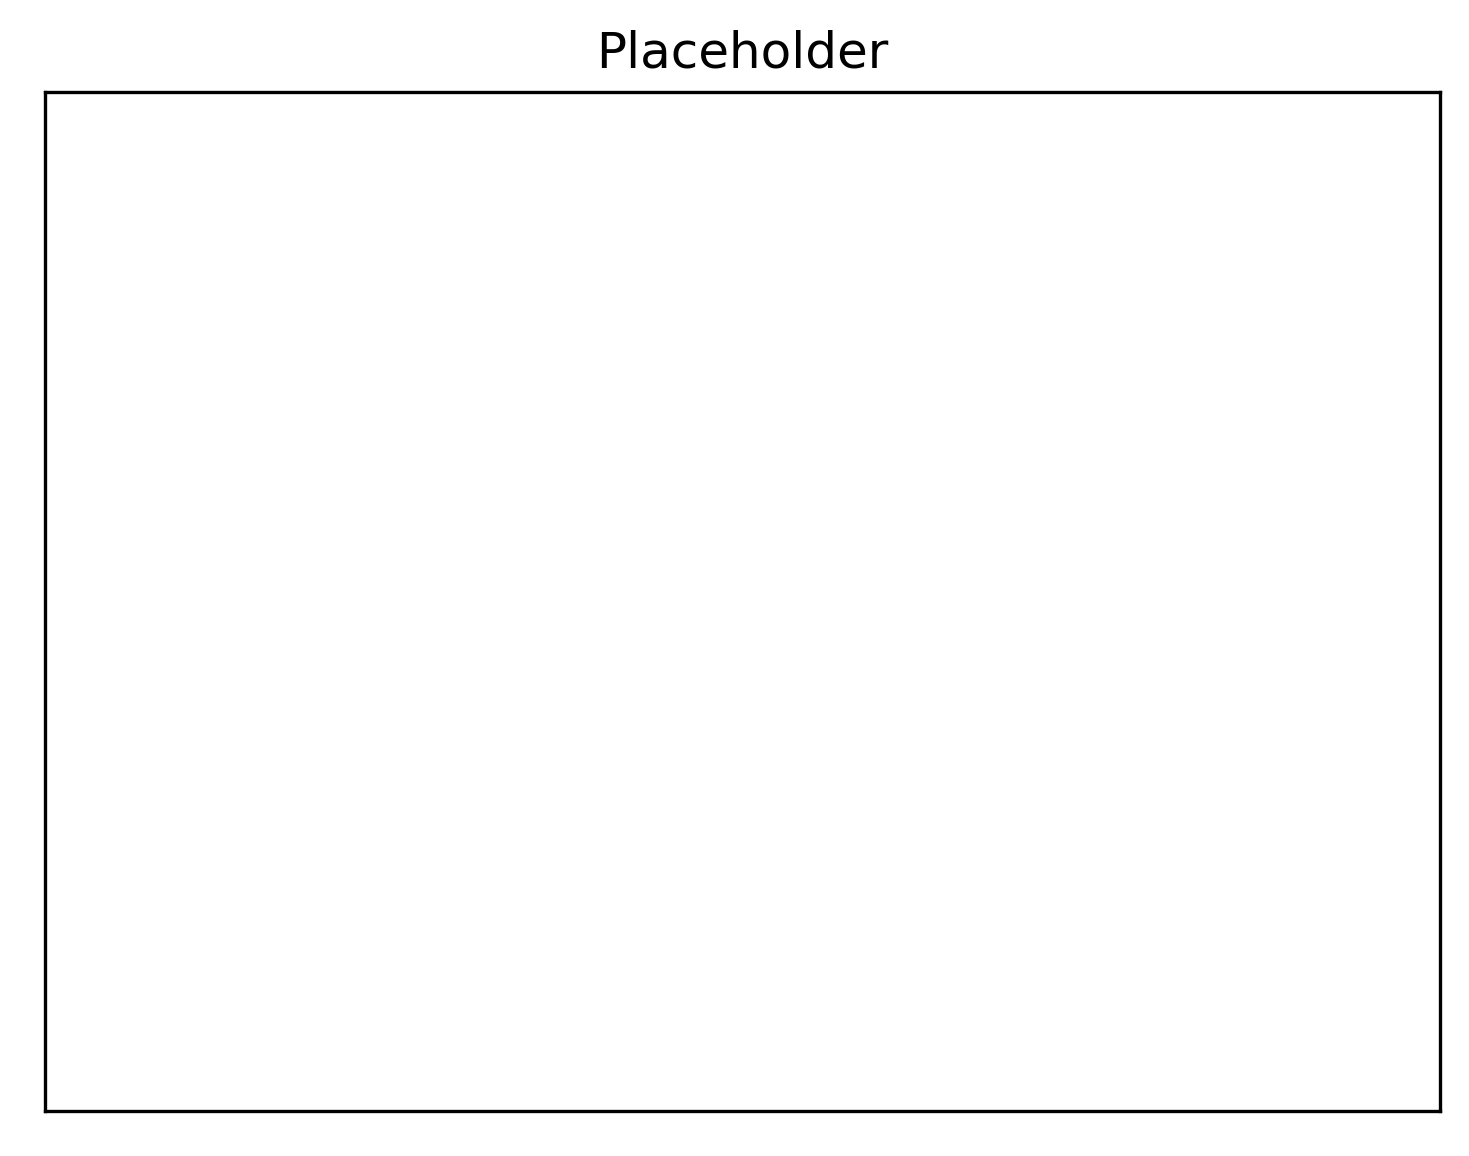

In [70]:
fig = plt.figure(figsize = (6, 4.5), dpi = 300)
ax  = fig.gca()
ax.set_title("Placeholder")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

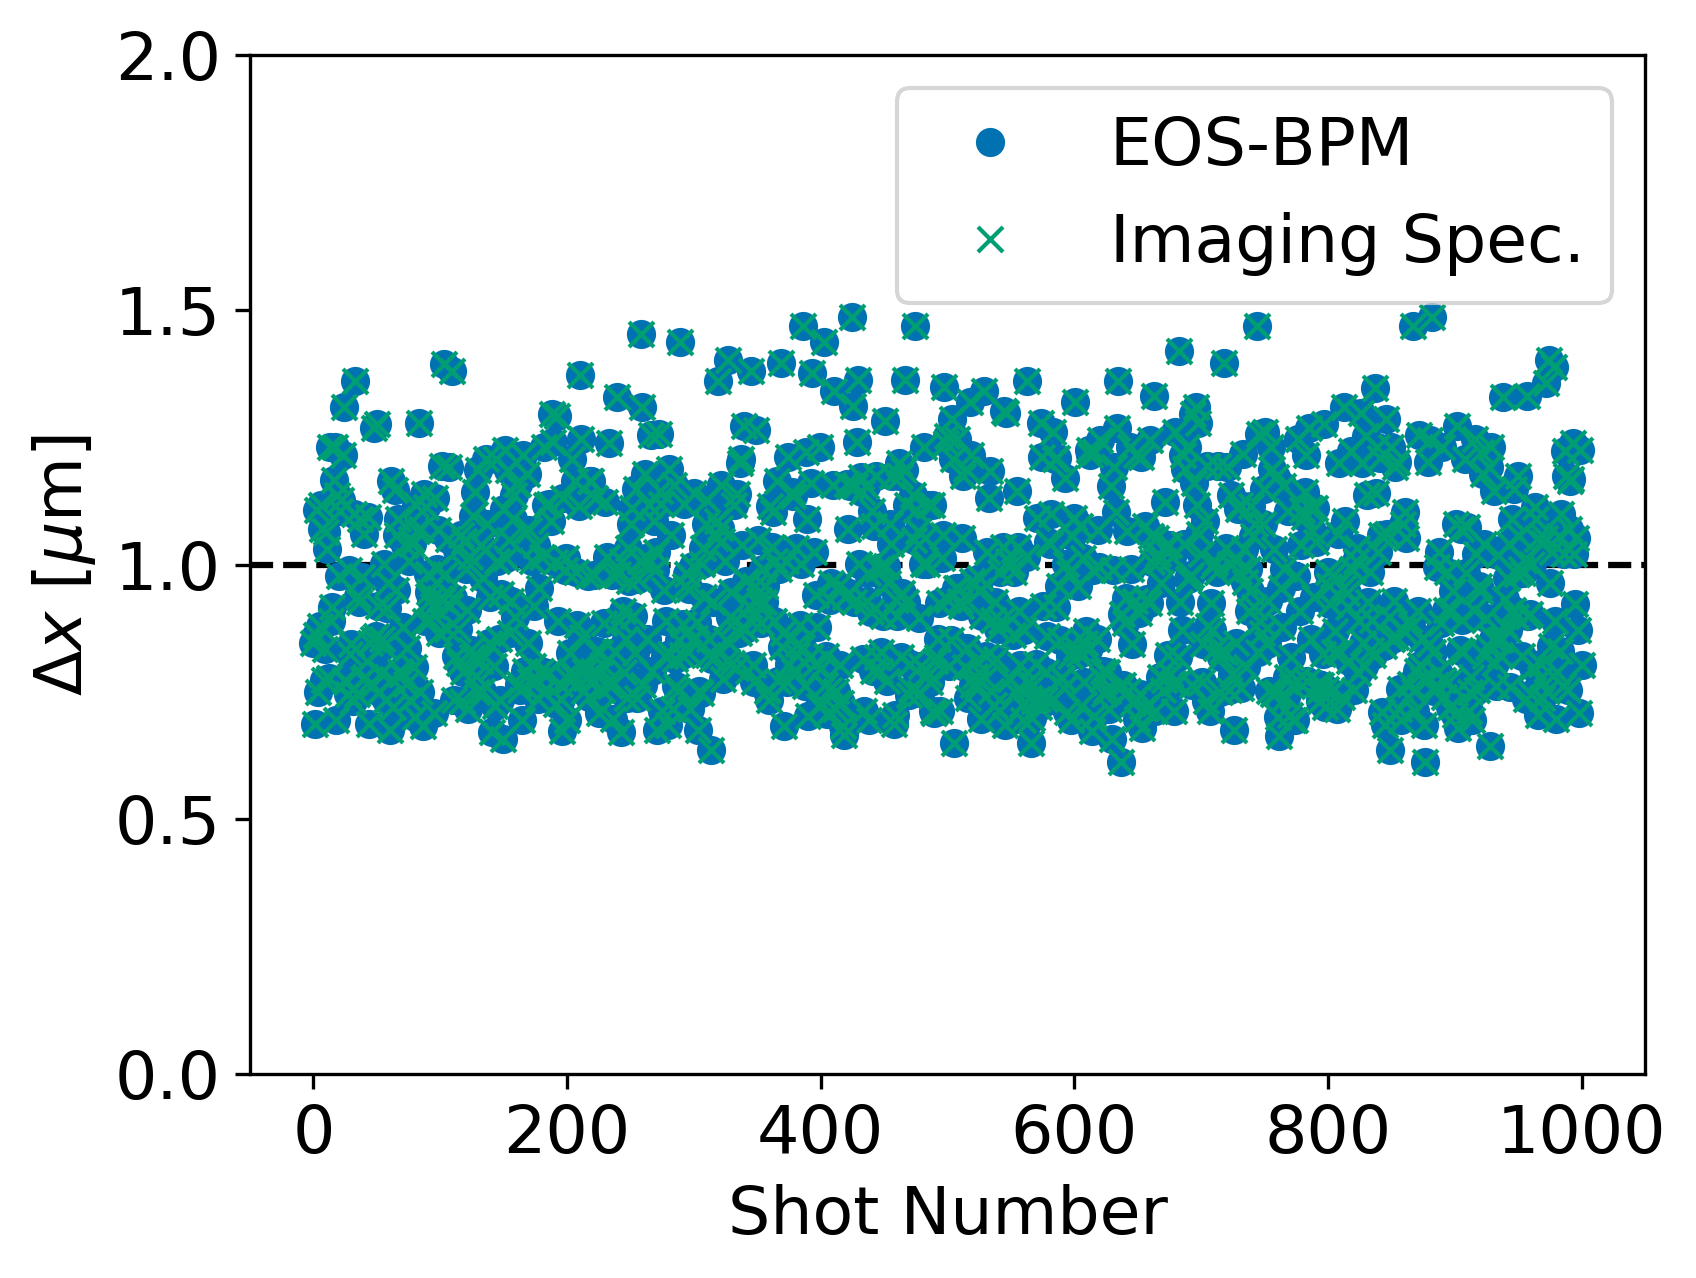

In [63]:
fig = plt.figure(figsize = (6, 4.5), dpi = 300)
fs  = 16
lw  = 2.5
ax  = fig.gca()
ax.set_xlabel('Shot Number', fontsize = fs)
ax.set_ylabel(r'$\Delta x$ [$\mu$m]', fontsize = fs)
ax.tick_params(axis = "both", labelsize = fs)
ax.axhline(y=1, color = "k", linestyle = '--')
ax.plot(N_arr, -dx_eos*1e6, 'o', label = "EOS-BPM", linewidth = lw)
ax.plot(N_arr, -dx_imag*1e6,'x', label = "Imaging Spec.", linewidth = lw)
ax.legend(fontsize = fs)
ax.set_ylim([0, 2])
plt.show()

In [64]:
# Figure: longitudinal measurement of EOS-BPM vs TCAV
N_shots = 1000
N_arr   = np.linspace(0, N_shots, N_shots)
# Preallocate
dz_tcav = np.zeros(N_shots)
dz_eos  = np.zeros(N_shots)
dt      = 8
setup["tau"] = np.arange(-500, 1000+dt, dt)*1e-15
upd = int(N_shots/10)
for i in range(N_shots):
    if (i+1)%upd == 0:
        print(i+1, "of", N_shots)
    ind        = random.randint(0, 3135)
    I, ti, p2p = cp.get_current(ind, cpath)
    dz_tcav[i] = c*p2p
    sig, tsig  = eos.get_signal(ind, setup)
    w_ind      = np.argmin(abs(tsig-250e-15))
    ind1      = np.argmax(sig[0:w_ind])
    ind2      = np.argmax(sig[w_ind:-1])+w_ind
    dz_eos[i] = c*(tsig[ind2]-tsig[ind1]) 

100 of 1000
200 of 1000
300 of 1000
400 of 1000
500 of 1000
600 of 1000
700 of 1000
800 of 1000
900 of 1000
1000 of 1000


In [128]:
xdata[0]-ydata[0]

-8.032126252605849

In [132]:
ind = np.argwhere(xdata > 130)
err  = abs(xdata[ind]-ydata[ind])/abs(xdata[ind])
print(np.nanmean(err*1e2))

1.325766084381346


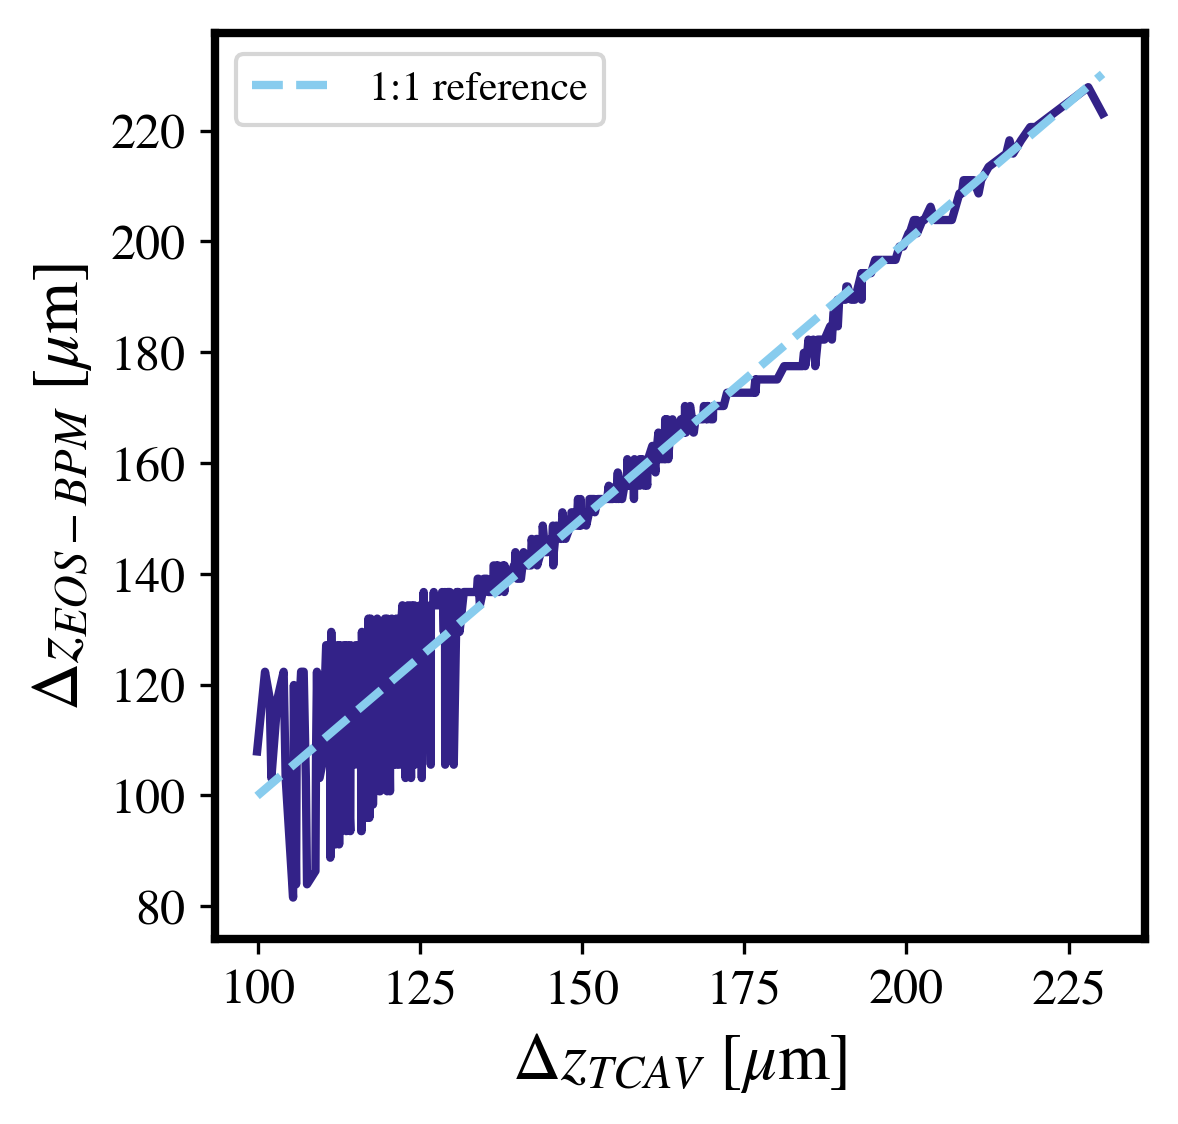

In [129]:
xdata = dz_tcav
inds  = np.argsort(xdata)
xdata = xdata[inds]*1e6
ydata = dz_eos[inds]*1e6
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel(r'$\Delta z_{TCAV}$ [$\mu$m]')
ax.set_ylabel(r'$\Delta z_{EOS-BPM}$ [$\mu$m]')
ax.plot(xdata, ydata)
ax.plot(xdata, xdata, '--', label = "1:1 reference")
ax.legend()
#ax.axvline(x=132)
plt.show()

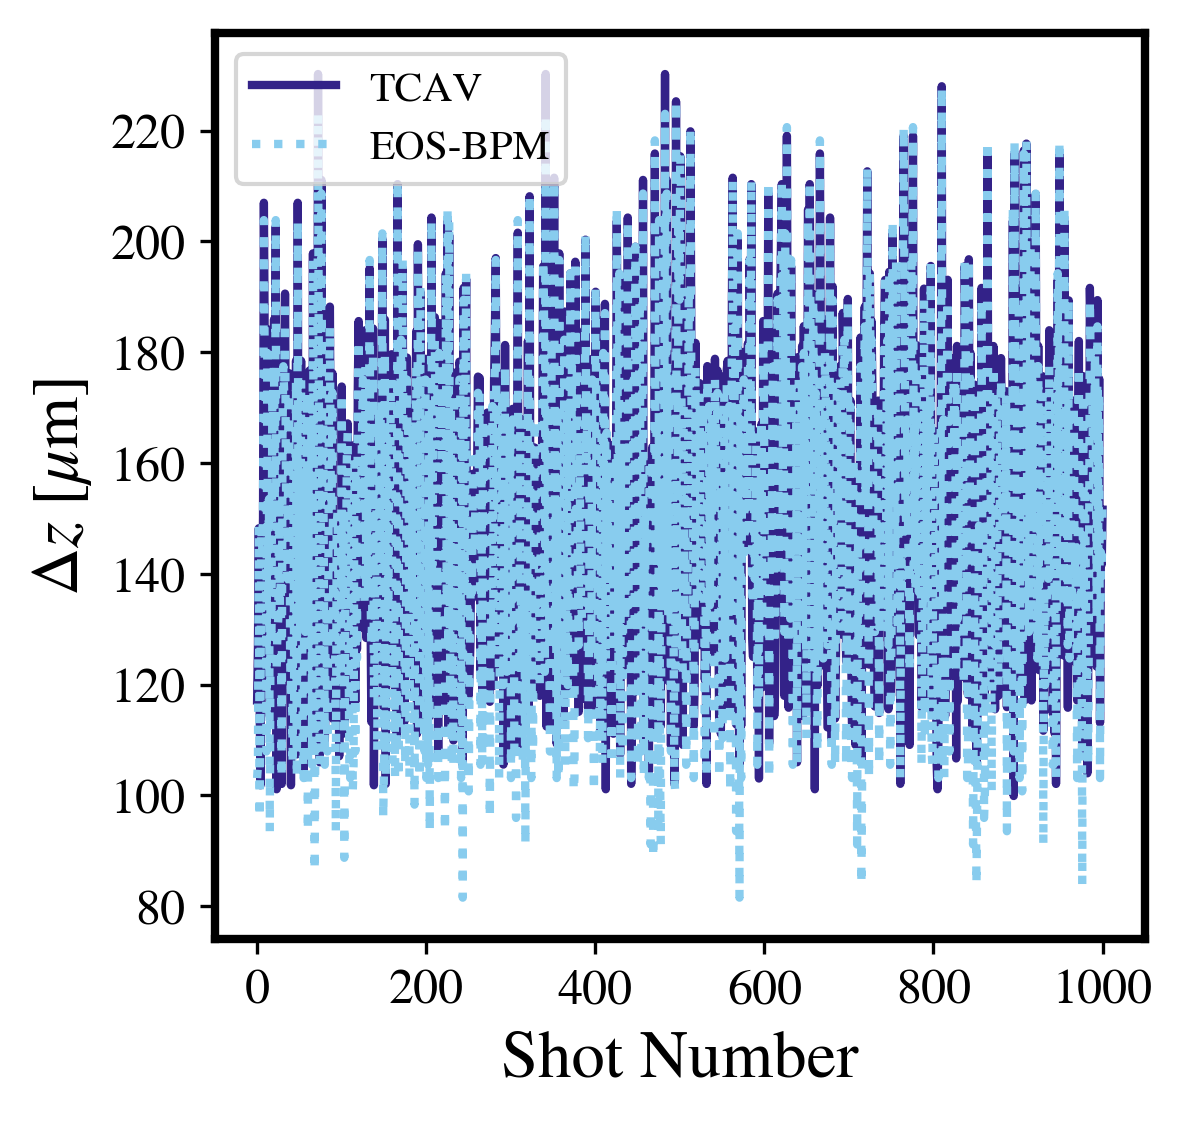

In [66]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Shot Number")
ax.set_ylabel(r'$\Delta z$ [$\mu$m]')
ax.plot(N_arr, dz_tcav*1e6, '-', label = "TCAV")
ax.plot(N_arr, dz_eos*1e6, ':', label = "EOS-BPM")
ax.legend()
plt.show()

In [68]:
# Figure: dx on screen vs dx on eos-bpm
# Some constants
gma   = 20000
beta  = np.sqrt(1-1/gma**2)
E     = 10e9 # eV
betad = 0.15 # m
betas = 0.15 # m
dpsi  = 0.78 # rad
phi   = 0*(np.pi/180)
lmd   = 2.6e-2
k     = 2*np.pi/lmd
pref  = (1/E)*np.sqrt(betad*betas)*np.sin(dpsi)
def get_dx(V0, z):
    dx = (2*np.pi*z/lmd)*np.cos(phi)+np.sin(phi)
    dx = dx*pref*V0
    return dx

In [96]:
N_shots   = 1000
N_arr     = np.linspace(0, N_shots, N_shots)
dx_screen = np.zeros(N_shots)
dx_eos    = np.zeros(N_shots)
upd       = int(N_shots/10)
for i in range(N_shots):
    if (i+1)%upd==0:
        print(i+1, "of", N_shots)
    ind = random.randint(0, 3134)
    I, ti, p2p = cp.get_current(ind, cpath)
    t_shift = 100e-15
    ti = ti + t_shift
    zi     = c*ti
    t_ind = np.argmin(abs(ti-(250e-15+t_shift)))
    d_ind = np.argmax(I[0:t_ind])
    w_ind = np.argmax(I[t_ind:-1])+t_ind
    dx     = get_dx(25e6, zi)
    dxd    = dx[d_ind]
    dxw    = dx[w_ind]
    dx_screen[i] = abs(dxd-dxw)
    # Drive beam
    rp           = 2.5e-3 + dxd
    rm           = 2.5e-3 - dxd
    Ep, tep      = cp.get_E(I, ti, rp)
    Em, tem      = cp.get_E(I, ti, rm)
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam  = eos.E_signal(Em, tem, setup)
    tw_ind = np.argmin(abs(tsigp-250e-15))
    indd   = np.argmax(sigp[0:tw_ind])
    # Centroid position
    Rd_num  = sigp[indd] - sigm[indd]
    Rd_den  = sigp[indd] + sigm[indd]
    Rd      = Rd_num/Rd_den
    g0d     = 2*np.arcsin(np.sqrt(0.5*Rd_den))
    dxd_eos = -(2.5e-3/g0d)*np.tan(0.5*g0d)*Rd
    # Witness beam
    rp     = 2.5e-3+dxw
    rm     = 2.5e-3-dxw
    Ep, tep      = cp.get_E(I, ti, rp)
    Em, tem      = cp.get_E(I, ti, rm)
    setup["tau"] = tep
    sigp, tsigp, gammap, tgammap = eos.E_signal(Ep, tep, setup)
    sigm, tsigm, gammam, tgammam  = eos.E_signal(Em, tem, setup)
    tw_ind = np.argmin(abs(tsigp-250e-15))
    indw   = np.argmax(sigp[tw_ind:-1]) + tw_ind
    # Witness centroid position
    Rw_num  = sigp[indw] - sigm[indw]
    Rw_den  = sigp[indw] + sigm[indw]
    Rw      = Rw_num/Rw_den
    g0w     = 2*np.arcsin(np.sqrt(0.5*Rw_den))
    dxw_eos = -(2.5e-3/g0w)*np.tan(0.5*g0w)*Rw
    dx_eos[i] = abs(dxd_eos-dxw_eos)
    #print(dx_screen[i]*1e6, dx_eos[i]*1e6)

100 of 1000
200 of 1000
300 of 1000
400 of 1000
500 of 1000
600 of 1000
700 of 1000
800 of 1000
900 of 1000
1000 of 1000


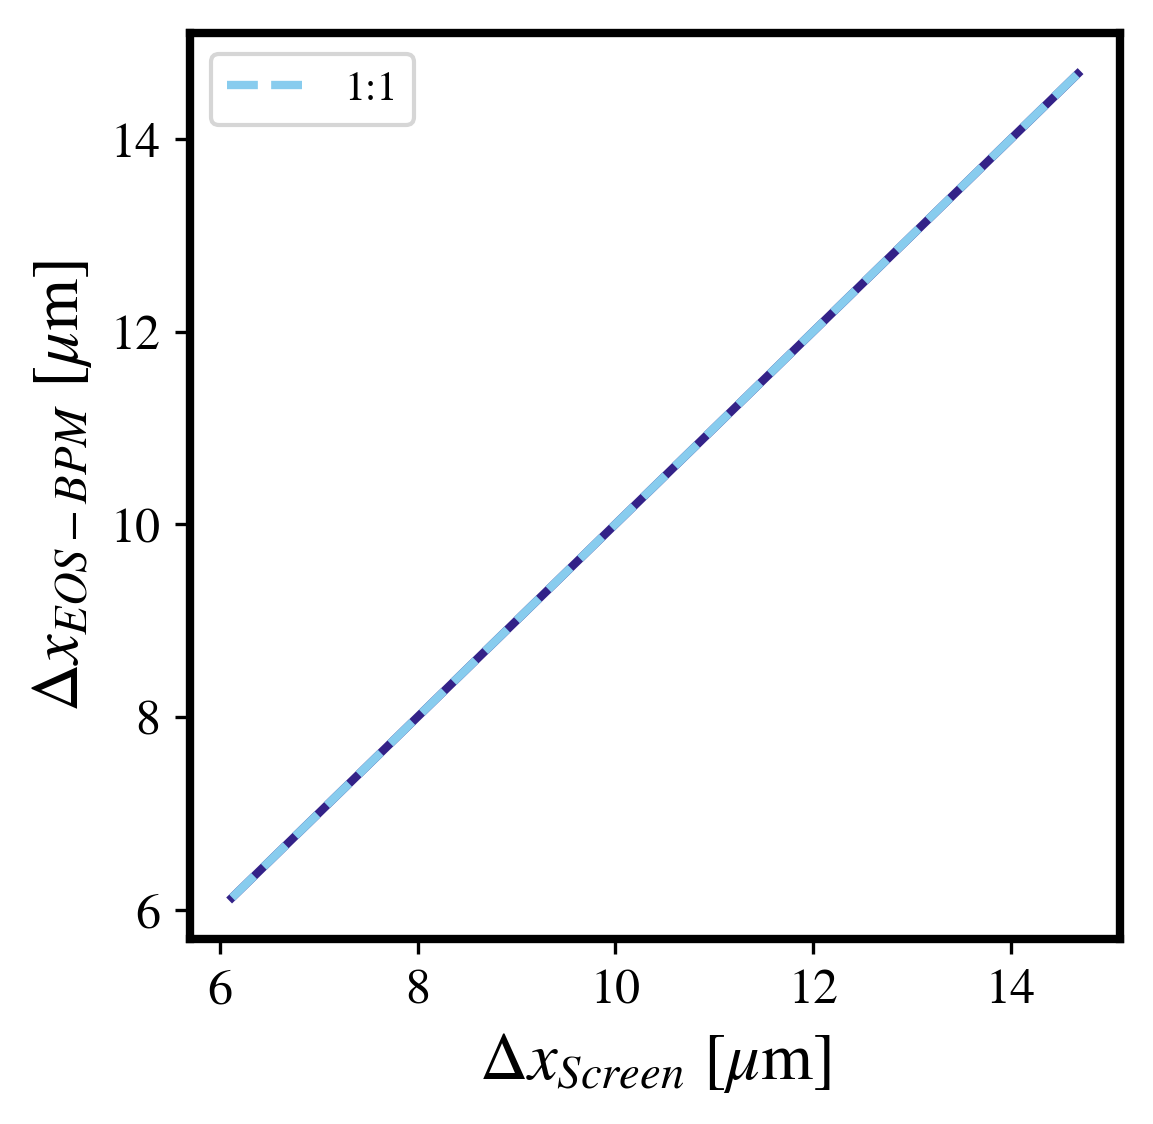

In [116]:
xdata = dx_screen
inds  = np.argsort(xdata)
xdata = xdata[inds]*1e6
ydata = dx_eos[inds]*1e6
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel(r'$\Delta x_{Screen}$ [$\mu$m]')
ax.set_ylabel(r'$\Delta x_{EOS-BPM}$ [$\mu$m]')
ax.plot(xdata, ydata, '-')
plt.plot(xdata, xdata, '--', label = "1:1")
ax.legend()
plt.show()

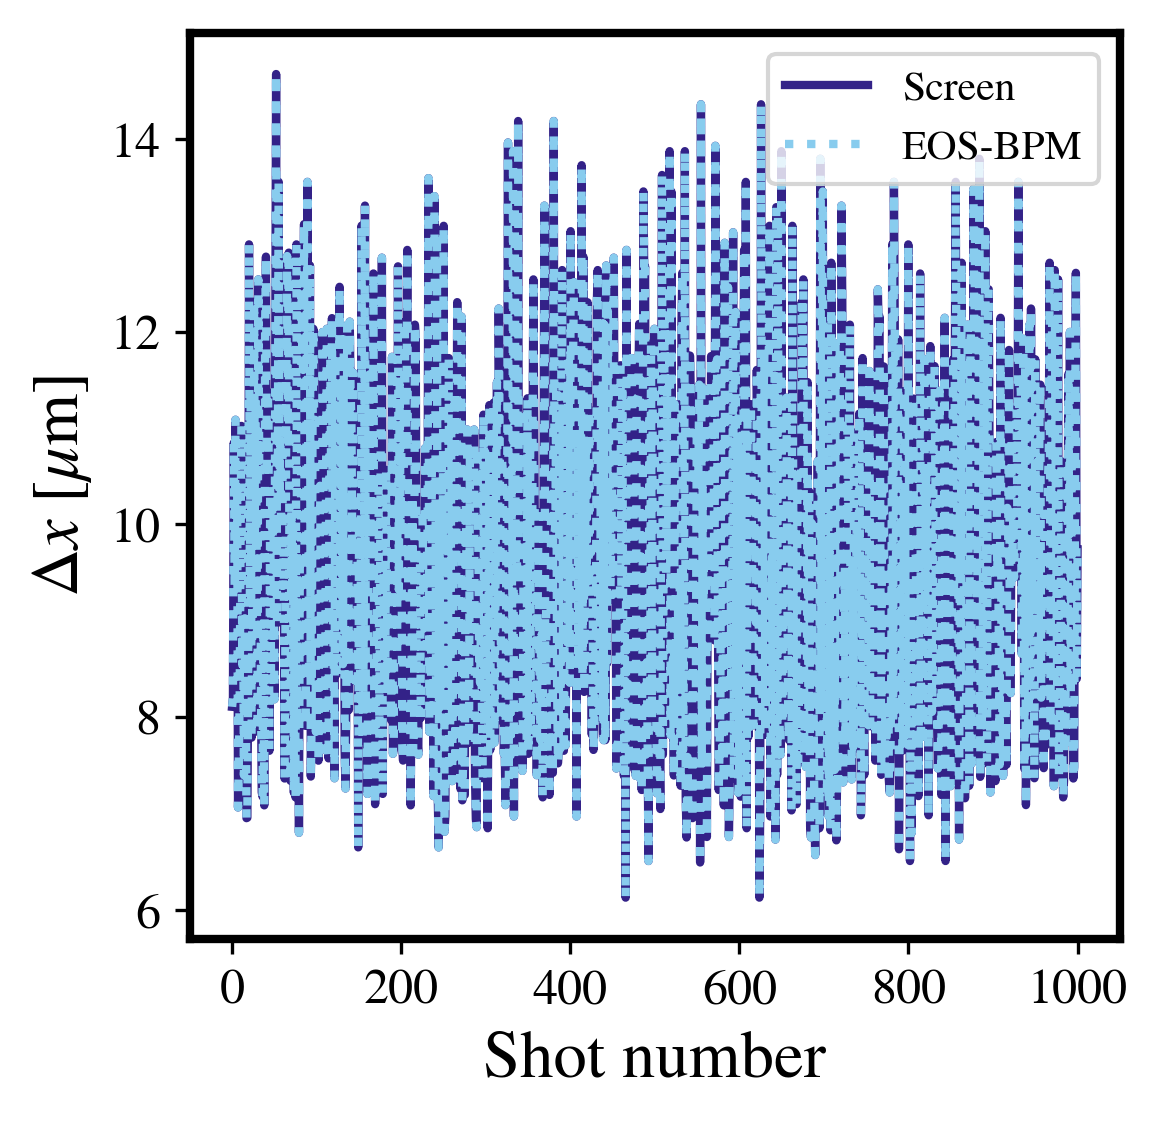

In [99]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Shot number")
ax.set_ylabel(r'$\Delta x$ [$\mu$m]')
ax.plot(N_arr, dx_screen*1e6, label = "Screen")
ax.plot(N_arr, dx_eos*1e6, ':', label = "EOS-BPM")
ax.legend()
plt.show()